# GroundingDINO Image Detection Pipeline

Simple notebook to:
1. Load GroundingDINO model
2. Use `get_image_id_paths()` to find images
3. Run object detection on zebrafish embryos

In [1]:
# Setup and Imports
import os
import sys
import yaml
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from typing import List, Union

# Project paths
SANDBOX_ROOT = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox")
utils_path = SANDBOX_ROOT / "scripts" / "utils"
sys.path.append(str(utils_path))

# Add GroundingDINO to path
groundingdino_path = SANDBOX_ROOT / "models" / "GroundingDINO"
sys.path.insert(0, str(groundingdino_path))

print(f"✅ Sandbox root: {SANDBOX_ROOT}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ CUDA device: {torch.cuda.get_device_name()}")

✅ Sandbox root: /net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox
✅ PyTorch version: 2.5.1
✅ CUDA available: True
✅ CUDA device: NVIDIA L40S


In [2]:
# Import experiment metadata utilities
from experiment_metadata_utils import get_image_id_paths, load_experiment_metadata

# Load experiment metadata
experiment_metadata_path = SANDBOX_ROOT / "data" / "raw_data_organized" / "experiment_metadata.json"
experiment_metadata = load_experiment_metadata(experiment_metadata_path)

print(f"✅ Loaded experiment metadata")
print(f"   Total experiments: {len(experiment_metadata.get('experiment_ids', []))}")
print(f"   Total images: {len(experiment_metadata.get('image_ids', []))}")

# Show first few available image IDs
all_image_ids = experiment_metadata.get('image_ids', [])
if all_image_ids:
    print(f"   Sample image IDs: {all_image_ids[:5]}")

✅ Loaded experiment metadata
   Total experiments: 16
   Total images: 84226
   Sample image IDs: ['20240812_E12_0000', '20240812_E12_0001', '20240812_E12_0002', '20240812_E12_0003', '20240812_E12_0004']


In [3]:
# Load GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate
print("✅ GroundingDINO imports successful")

# Load configuration
config_path = SANDBOX_ROOT / "configs" / "pipeline_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Model paths
groundingdino_config = SANDBOX_ROOT / config["models"]["groundingdino"]["config"]
groundingdino_weights = SANDBOX_ROOT / config["models"]["groundingdino"]["weights"]

print(f"   Config: {groundingdino_config.exists()}")
print(f"   Weights: {groundingdino_weights.exists()}")

# Load model (try CUDA first, fallback to CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n🔄 Loading GroundingDINO model on {device}...")

model = load_model(
    str(groundingdino_config),
    str(groundingdino_weights),
    device=device
)

print(f"✅ GroundingDINO model loaded successfully on {device}!")
groundingdino_ready = True
  

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/segmentation_grounded_sam/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


✅ GroundingDINO imports successful
   Config: True
   Weights: True

🔄 Loading GroundingDINO model on cuda...


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/segmentation_grounded_sam/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/models/GroundingDINO/groundingdino/util/inference.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  che

✅ GroundingDINO model loaded successfully on cuda!


In [4]:
# Test get_image_id_paths function
print("=== Testing get_image_id_paths Function ===")

# Test single image
if all_image_ids:
    test_image_id = all_image_ids[0]
    print(f"\n🔍 Testing single image: {test_image_id}")
    
    single_path = get_image_id_paths(test_image_id, experiment_metadata)
    print(f"   Path: {single_path}")
    print(f"   Exists: {single_path.exists() if single_path else False}")
    
    # Test batch images
    batch_image_ids = all_image_ids[:3]  # First 3 images
    print(f"\n🔍 Testing batch images: {batch_image_ids}")
    
    batch_paths = get_image_id_paths(batch_image_ids, experiment_metadata)
    print(f"   Loaded {len(batch_paths)} image paths")
    
    for i, (img_id, path) in enumerate(zip(batch_image_ids, batch_paths)):
        exists = path.exists() if path else False
        print(f"   {i+1}. {img_id}: {exists}")
        
    # Store for inference
    test_image_paths = [p for p in batch_paths if p and p.exists()]
    test_image_ids = [batch_image_ids[i] for i, p in enumerate(batch_paths) if p and p.exists()]
    
    print(f"\n✅ Ready for inference with {len(test_image_paths)} valid images")
    
else:
    print("❌ No image IDs available in metadata")
    test_image_paths = []
    test_image_ids = []

=== Testing get_image_id_paths Function ===

🔍 Testing single image: 20240812_E12_0000
   Path: /net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/data/raw_data_organized/20240812/images/20240812_E12/20240812_E12_0000.jpg
   Exists: True

🔍 Testing batch images: ['20240812_E12_0000', '20240812_E12_0001', '20240812_E12_0002']
   Loaded 3 image paths
   1. 20240812_E12_0000: True
   2. 20240812_E12_0001: True
   3. 20240812_E12_0002: True

✅ Ready for inference with 3 valid images


In [5]:
# GroundingDINO Inference
if groundingdino_ready and test_image_paths:
    print("=== Running GroundingDINO Inference ===")
    
    # Detection parameters
    TEXT_PROMPT = "embryo . fish . zebrafish embryo . organism"
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25
    
    print(f"Text prompt: '{TEXT_PROMPT}'")
    print(f"Box threshold: {BOX_THRESHOLD}")
    print(f"Text threshold: {TEXT_THRESHOLD}")
    print(f"Device: {device}")
    
    results = []
    
    for i, (image_id, image_path) in enumerate(zip(test_image_ids, test_image_paths)):
        print(f"\n--- Processing {i+1}/{len(test_image_paths)}: {image_id} ---")
        
        try:
            # Load image
            image_source, image_tensor = load_image(str(image_path))
            print(f"   ✅ Image loaded: {image_tensor.shape}")
            
            # Run inference
            with torch.no_grad():
                boxes, logits, phrases = predict(
                    model=model,
                    image=image_tensor,
                    caption=TEXT_PROMPT,
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD
                )
            
            num_detections = len(boxes)
            print(f"   ✅ Inference complete: {num_detections} detections")
            
            # Store results
            result = {
                'image_id': image_id,
                'image_path': image_path,
                'image_source': image_source,
                'boxes': boxes,
                'logits': logits,
                'phrases': phrases,
                'num_detections': num_detections
            }
            results.append(result)
            
            # Print detection details
            if num_detections > 0:
                for j, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
                    confidence = logit.item()
                    print(f"     Detection {j+1}: {phrase} (confidence: {confidence:.3f})")
            else:
                print(f"     No detections above threshold")
                
        except Exception as e:
            print(f"   ❌ Error processing {image_id}: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"\n✅ Completed inference on {len(results)} images")
    total_detections = sum(r['num_detections'] for r in results)
    print(f"📊 Total detections: {total_detections}")
    
else:
    print("❌ Skipping inference - GroundingDINO not ready or no images available")
    results = []

=== Running GroundingDINO Inference ===
Text prompt: 'embryo . fish . zebrafish embryo . organism'
Box threshold: 0.35
Text threshold: 0.25
Device: cuda

--- Processing 1/3: 20240812_E12_0000 ---
   ✅ Image loaded: torch.Size([3, 1333, 702])


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/segmentation_grounded_sam/lib/python3.10/site-packages/transformers/modeling_utils.py:1731: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/segmentation_grounded_sam/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/segmentation_grounded_sam/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=Tr

   ✅ Inference complete: 3 detections
     Detection 1: zebrafish embryo (confidence: 0.425)
     Detection 2: zebrafish embryo (confidence: 0.433)
     Detection 3: embryo (confidence: 0.448)

--- Processing 2/3: 20240812_E12_0001 ---
   ✅ Image loaded: torch.Size([3, 1333, 702])
   ✅ Inference complete: 3 detections
     Detection 1: zebrafish embryo (confidence: 0.434)
     Detection 2: embryo (confidence: 0.456)
     Detection 3: zebrafish embryo (confidence: 0.418)

--- Processing 3/3: 20240812_E12_0002 ---
   ✅ Image loaded: torch.Size([3, 1333, 702])
   ✅ Inference complete: 3 detections
     Detection 1: zebrafish embryo (confidence: 0.438)
     Detection 2: embryo (confidence: 0.451)
     Detection 3: zebrafish embryo (confidence: 0.406)

✅ Completed inference on 3 images
📊 Total detections: 9


=== Visualizing Detection Results ===

📷 Image 1: 20240812_E12_0000 (3 detections)


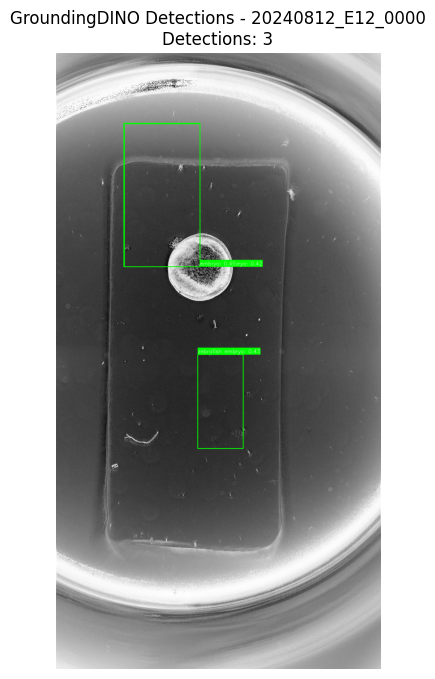

=== Visualizing Detection Results ===

📷 Image 1: 20240812_E12_0000 (3 detections)


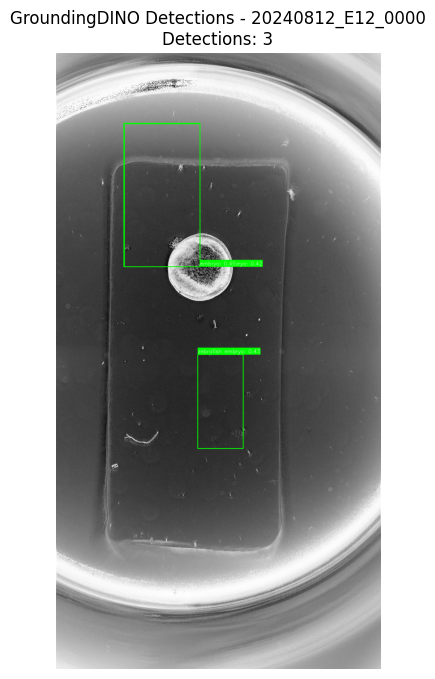

   Detections:
     1. zebrafish embryo: 0.425
     2. zebrafish embryo: 0.433
     3. embryo: 0.448

📷 Image 2: 20240812_E12_0001 (3 detections)


=== Visualizing Detection Results ===

📷 Image 1: 20240812_E12_0000 (3 detections)


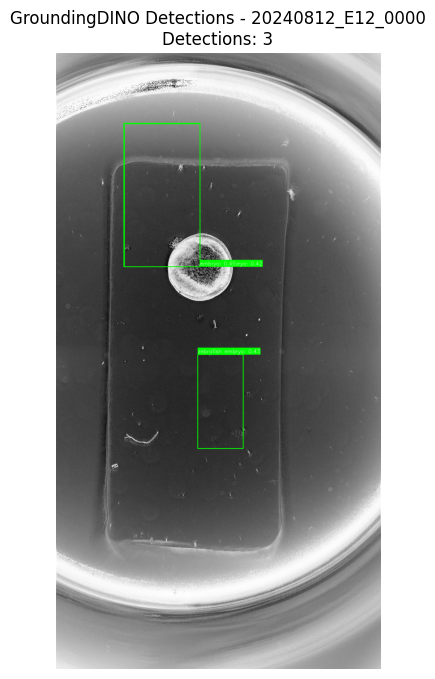

   Detections:
     1. zebrafish embryo: 0.425
     2. zebrafish embryo: 0.433
     3. embryo: 0.448

📷 Image 2: 20240812_E12_0001 (3 detections)


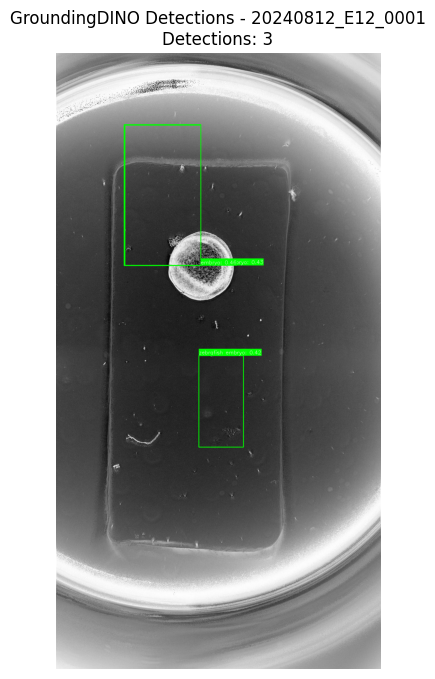

   Detections:
     1. zebrafish embryo: 0.434
     2. embryo: 0.456
     3. zebrafish embryo: 0.418

📷 Image 3: 20240812_E12_0002 (3 detections)


=== Visualizing Detection Results ===

📷 Image 1: 20240812_E12_0000 (3 detections)


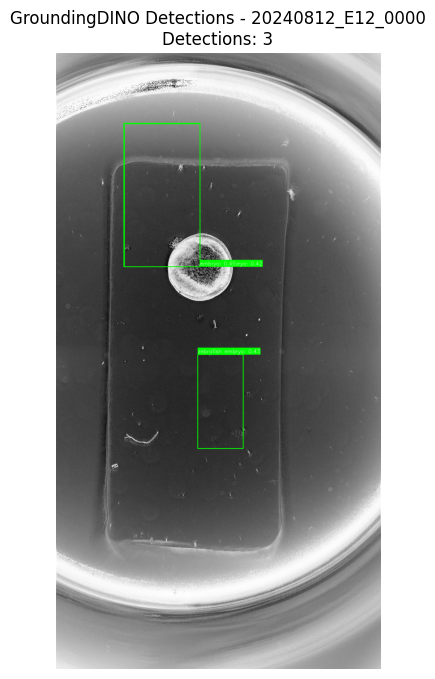

   Detections:
     1. zebrafish embryo: 0.425
     2. zebrafish embryo: 0.433
     3. embryo: 0.448

📷 Image 2: 20240812_E12_0001 (3 detections)


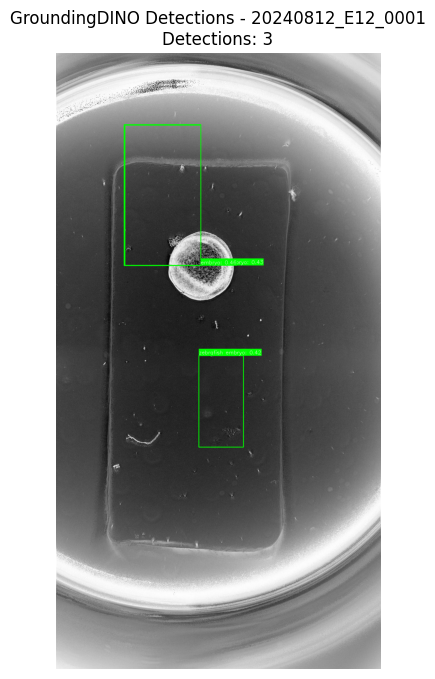

   Detections:
     1. zebrafish embryo: 0.434
     2. embryo: 0.456
     3. zebrafish embryo: 0.418

📷 Image 3: 20240812_E12_0002 (3 detections)


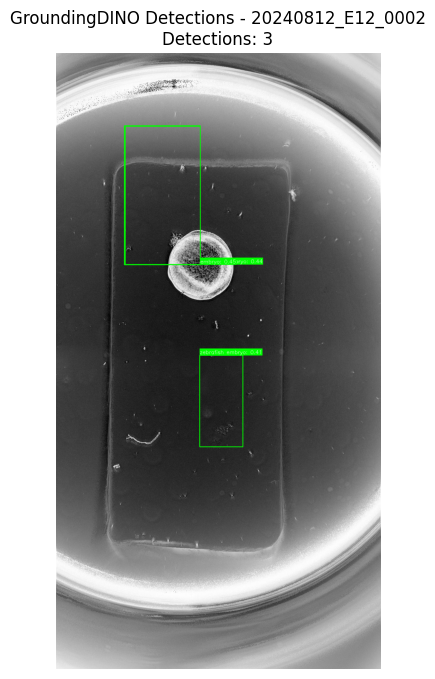

   Detections:
     1. zebrafish embryo: 0.438
     2. embryo: 0.451
     3. zebrafish embryo: 0.406


In [7]:
# Visualize Results
if results:
    print("=== Visualizing Detection Results ===")
    
    for i, result in enumerate(results):
        image_id = result['image_id']
        image_source = result['image_source']
        boxes = result['boxes']
        logits = result['logits']
        phrases = result['phrases']
        num_detections = result['num_detections']
        
        print(f"\n📷 Image {i+1}: {image_id} ({num_detections} detections)")
        
        if num_detections > 0:
            # Create annotated image
            try:
                annotated_frame = annotate(
                    image_source=image_source,
                    boxes=boxes,
                    logits=logits,
                    phrases=phrases
                )
                
                # Convert BGR to RGB for matplotlib
                annotated_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
                
                # Display
                plt.figure(figsize=(12, 8))
                plt.imshow(annotated_rgb)
                plt.title(f"GroundingDINO Detections - {image_id}\nDetections: {num_detections}")
                plt.axis('off')
                plt.show()
                
            except Exception as e:
                print(f"   ❌ Visualization error: {e}")
                # Fallback: show original image
                image_rgb = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 6))
                plt.imshow(image_rgb)
                plt.title(f"Original Image - {image_id}")
                plt.axis('off')
                plt.show()
        else:
            # Show original image if no detections
            image_rgb = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 6))
            plt.imshow(image_rgb)
            plt.title(f"No Detections - {image_id}")
            plt.axis('off')
            plt.show()
            
else:
    print("❌ No results to visualize")
    
    # Fallback: show sample images without inference
    if test_image_paths:
        print("\n📷 Showing sample images without inference:")
        
        for i, (image_id, image_path) in enumerate(zip(test_image_ids[:2], test_image_paths[:2])):
            try:
                image = cv2.imread(str(image_path))
                if image is not None:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(image_rgb)
                    plt.title(f"Sample Image - {image_id}")
                    plt.axis('off')
                    plt.show()
            except Exception as e:
                print(f"   ❌ Error loading {image_id}: {e}")

In [ ]:
# Summary
print("\n=== 🎉 Pipeline Summary ===")
print(f"✅ GroundingDINO ready: {groundingdino_ready}")
print(f"✅ Device used: {device if groundingdino_ready else 'N/A'}")
print(f"✅ Images processed: {len(results) if results else 0}")
print(f"✅ Total detections: {sum(r['num_detections'] for r in results) if results else 0}")
print(f"✅ get_image_id_paths function: Working")

if results:
    # Detection statistics
    images_with_detections = sum(1 for r in results if r['num_detections'] > 0)
    avg_detections = sum(r['num_detections'] for r in results) / len(results)
    
    print(f"\n📊 Detection Statistics:")
    print(f"   Images with detections: {images_with_detections}/{len(results)}")
    print(f"   Average detections per image: {avg_detections:.2f}")
    
    # Confidence statistics
    all_confidences = []
    for result in results:
        for logit in result['logits']:
            all_confidences.append(logit.item())
    
    if all_confidences:
        print(f"   Confidence range: {min(all_confidences):.3f} - {max(all_confidences):.3f}")
        print(f"   Mean confidence: {sum(all_confidences)/len(all_confidences):.3f}")

print("\n🚀 Pipeline ready for production use!")
print("\n💡 Usage example:")
print("   # Load single image")
print("   path = get_image_id_paths('20231206_A04_0000', experiment_metadata)")
print("   # Load batch images")
print("   paths = get_image_id_paths(['img1', 'img2', 'img3'], experiment_metadata)")